In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LIME to Inspect Text Classification




In [ ]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F

from captum.attr import visualization as viz
from captum.attr import Lime, LimeBase
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso

import os
import json

In [ ]:
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab as Vocab

from collections import Counter

from IPython.core.display import HTML, display

In [ ]:
import seaborn as sns
from pylab import rcParams

import matplotlib.pyplot as plt
from matplotlib import rc

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
sns.set_palette(sns.color_palette("Paired"))

rcParams['figure.figsize'] = 12,8

### 2.1 Load the data and define the model

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
path_train = '/content/drive/MyDrive/710 Project/train_ag.csv'
path_test = '/content/drive/MyDrive/710 Project/test_ag.csv'

In [ ]:
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

In [ ]:
print([df_test['label'][0],(df_test['title'][0],df_test['text'][0])])

[3, ('Fears for T N pension after talks', "Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.")]


[Text(0, 0, 'world'),
 Text(1, 0, 'sports'),
 Text(2, 0, 'business'),
 Text(3, 0, 'sci/tec')]

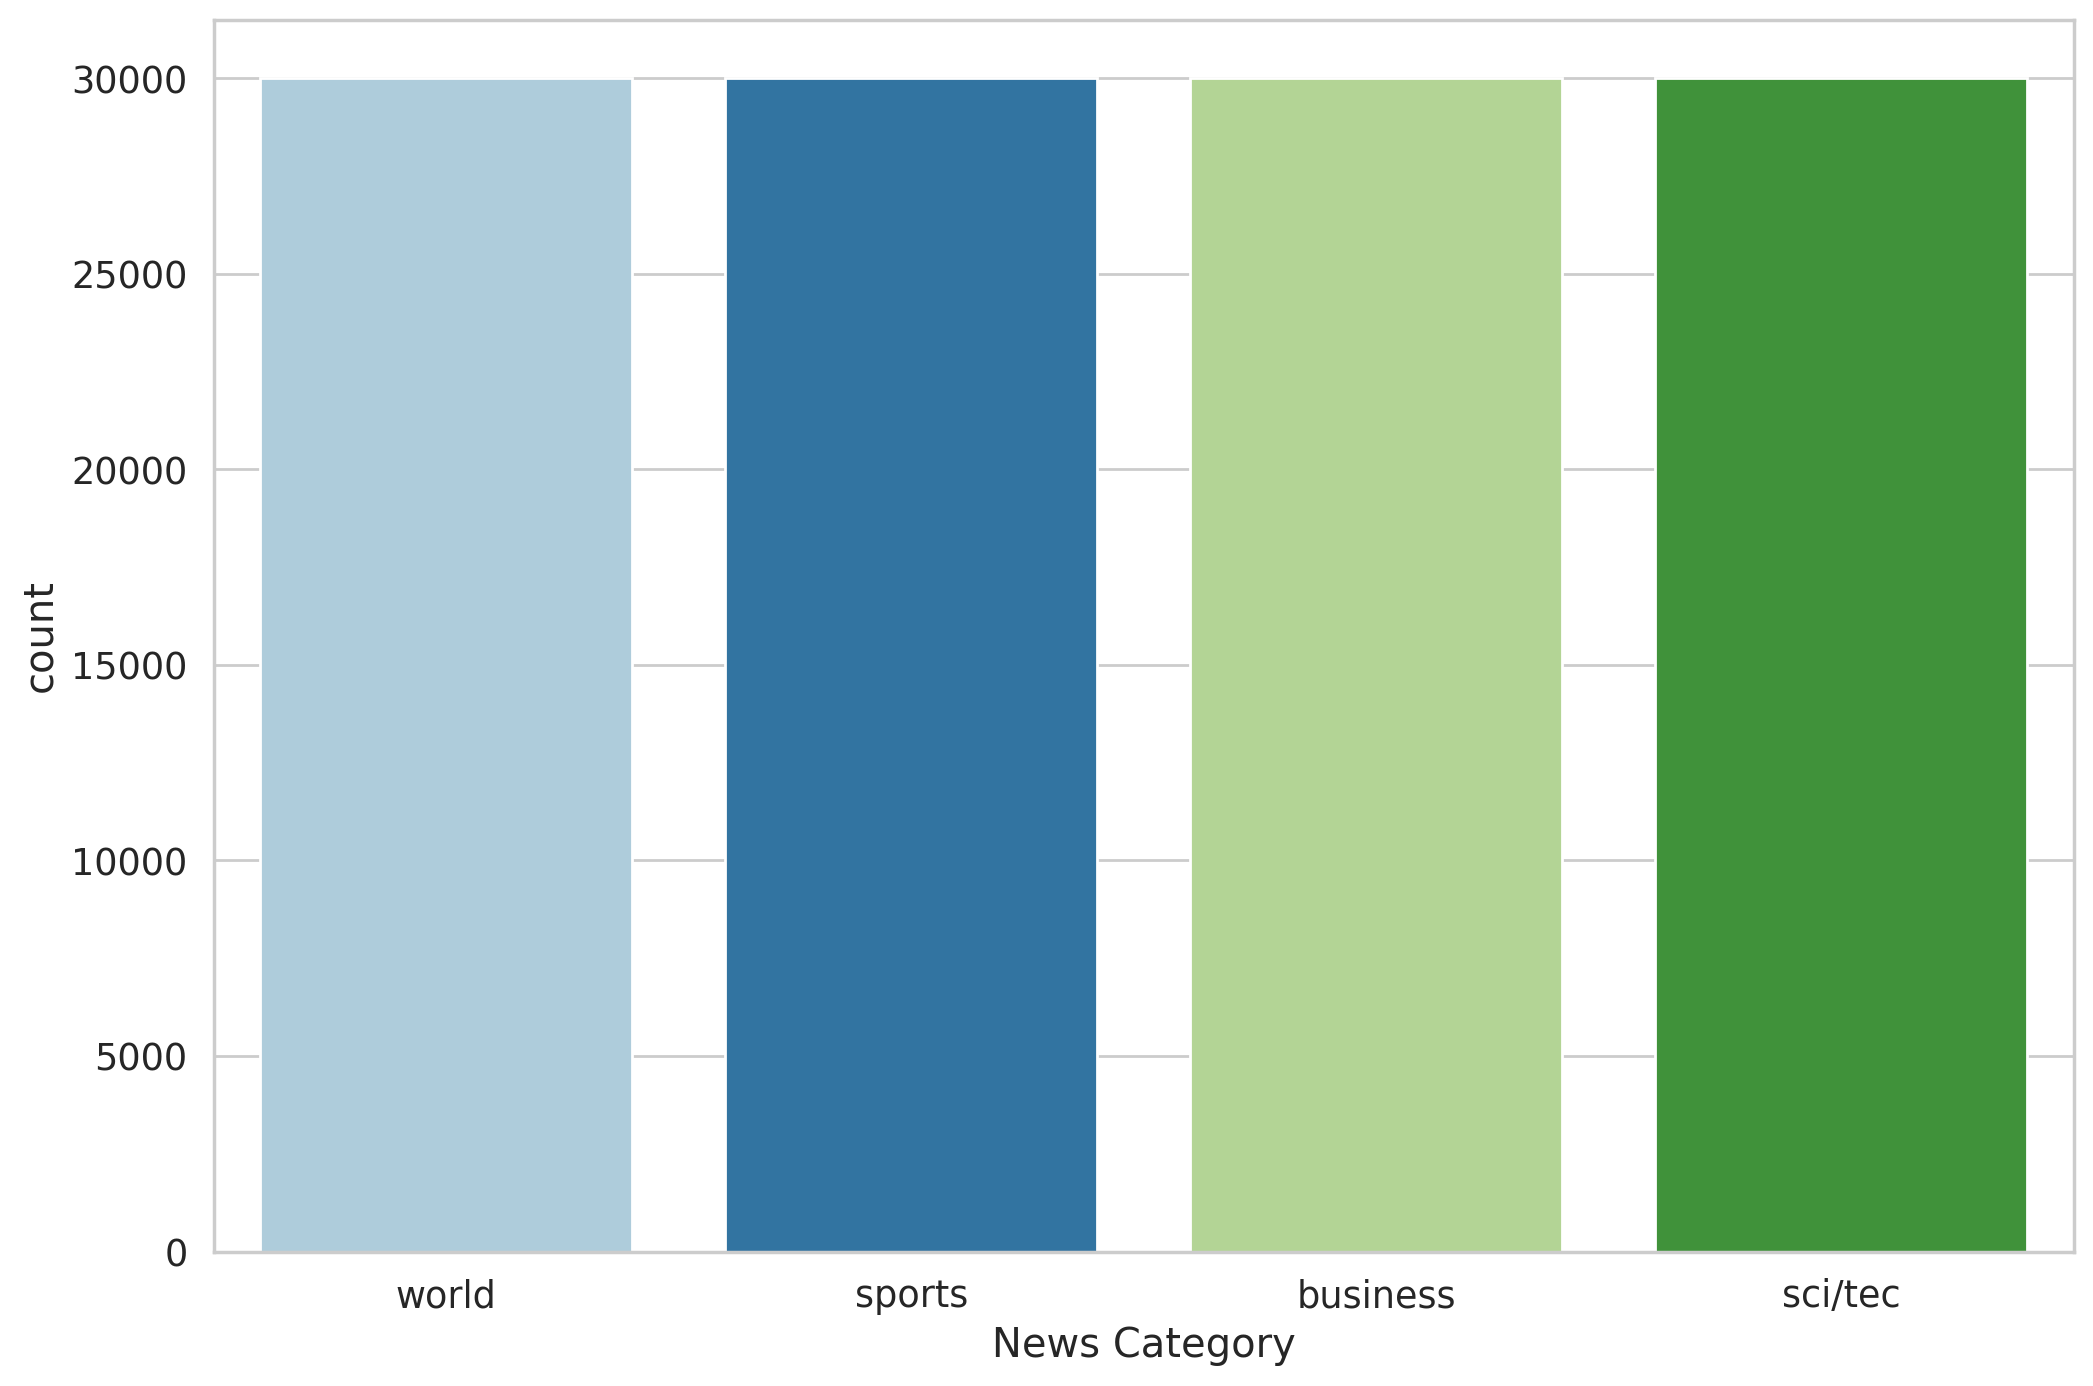

In [ ]:
class_names = ['world', 'sports', 'business', 'sci/tec']

ax = sns.countplot(data=df_train, x=df_train.label)
plt.xlabel('News Category')
ax.set_xticklabels(class_names)

In [ ]:
length = len(df_train['label'])

In [ ]:
ag_ds = []
for i in range(len(df_train['label'])):
  pack = (df_train['label'][i], df_train['text'][i])
  ag_ds.append(pack)

In [ ]:
ag_test = []
for i in range(len(df_test['label'])):
  pack = (df_test['label'][i], df_test['text'][i])
  ag_test.append(pack)

In [ ]:
len(ag_test)

7600

In [ ]:
ag_train, ag_val = ag_ds[:100000], ag_ds[100000:]

In [ ]:
tokenizer = get_tokenizer('basic_english')
word_counter = Counter()
for (label, line) in ag_ds:
    word_counter.update(tokenizer(line))
voc = Vocab(word_counter)

print('Vocabulary size:', len(voc))

num_class = len(set(label for label, _ in ag_train))
print('Num of classes:', num_class)

Vocabulary size: 88155
Num of classes: 4


In [ ]:
for (label, line) in ag_test:
    word_counter.update(tokenizer(line))
voc = Vocab(word_counter)
print('Vocabulary size:', len(voc))

Vocabulary size: 90723


In [ ]:
class EmbeddingBagModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
        self.linear = nn.Linear(embed_dim, num_class)

    def forward(self, inputs, offsets):
        embedded = self.embedding(inputs, offsets)
        return self.linear(embedded)

### 2.2 Training and Baseline Classification

In [ ]:
BATCH_SIZE = 64

def collate_batch(batch):
    labels = torch.tensor([label - 1 for label, _ in batch])
    text_list = [tokenizer(line) for _, line in batch]

    # flatten tokens across the whole batch
    text = torch.tensor([voc[t] for tokens in text_list for t in tokens])
    # the offset of each example
    offsets = torch.tensor(
        [0] + [len(tokens) for tokens in text_list][:-1]
    ).cumsum(dim=0)

    return labels, text, offsets

train_loader = DataLoader(ag_train, batch_size=BATCH_SIZE,
                          shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(ag_val, batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(ag_test, batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=collate_batch)

In [ ]:
EPOCHS = 7
EMB_SIZE = 64
CHECKPOINT = './drive/MyDrive/710 Project/models/embedding_bag_ag_news.pt'
USE_PRETRAINED = True  # change to False if you want to retrain your own model

def train_model(train_loader, val_loader):
    model = EmbeddingBagModel(len(voc), EMB_SIZE, num_class)

    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(1, EPOCHS + 1):
        # training
        model.train()
        total_acc, total_count = 0, 0

        for idx, (label, text, offsets) in enumerate(train_loader):
            optimizer.zero_grad()
            predited_label = model(text, offsets)
            loss(predited_label, label).backward()
            optimizer.step()
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_count += label.size(0)

            if (idx + 1) % 500 == 0:
                print('epoch {:3d} | {:5d}/{:5d} batches | accuracy {:8.3f}'.format(
                    epoch, idx + 1, len(train_loader), total_acc / total_count
                ))
                total_acc, total_count = 0, 0

        # evaluation
        model.eval()
        total_acc, total_count = 0, 0

        with torch.no_grad():
            for label, text, offsets in val_loader:
                predited_label = model(text, offsets)
                total_acc += (predited_label.argmax(1) == label).sum().item()
                total_count += label.size(0)

        print('-' * 59)
        print('end of epoch {:3d} | valid accuracy {:8.3f} '.format(epoch, total_acc / total_count))
        print('-' * 59)

    torch.save(model, CHECKPOINT)
    return model

eb_model = torch.load(CHECKPOINT) if USE_PRETRAINED else train_model(train_loader, val_loader)

In [ ]:
print(eb_model)

EmbeddingBagModel(
  (embedding): EmbeddingBag(90723, 64, mode='mean')
  (linear): Linear(in_features=64, out_features=4, bias=True)
)


In [ ]:
world_category, sports_category, business_category, sci_tec_category = [], [], [], []
for i in range(len(ag_test)):
  label, text = ag_test[i]
  if label == 1:
    world_category.append(ag_test[i])
  elif label == 2:
    sports_category.append(ag_test[i])
  elif label == 3:
    business_category.append(ag_test[i])
  elif label == 4:
    sci_tec_category.append(ag_test[i])


In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  true_labels = []

  total_acc, total_count = 0, 0

  with torch.no_grad():
    for idx, (labels, texts, offsets) in enumerate(data_loader):
      outputs = model(texts, offsets)
      total_acc += (outputs.argmax(1) == labels).sum().item()
      total_count += labels.size(0)
      _, preds = torch.max(outputs, dim=1)

      predictions.extend(preds.tolist())
      true_labels.extend(labels.tolist())

  return predictions, true_labels, total_acc/total_count

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

Test Accuracy: 0.9025
              precision    recall  f1-score   support

       world       0.91      0.91      0.91      1900
      sports       0.96      0.96      0.96      1900
    business       0.87      0.87      0.87      1900
     sci/tec       0.88      0.87      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



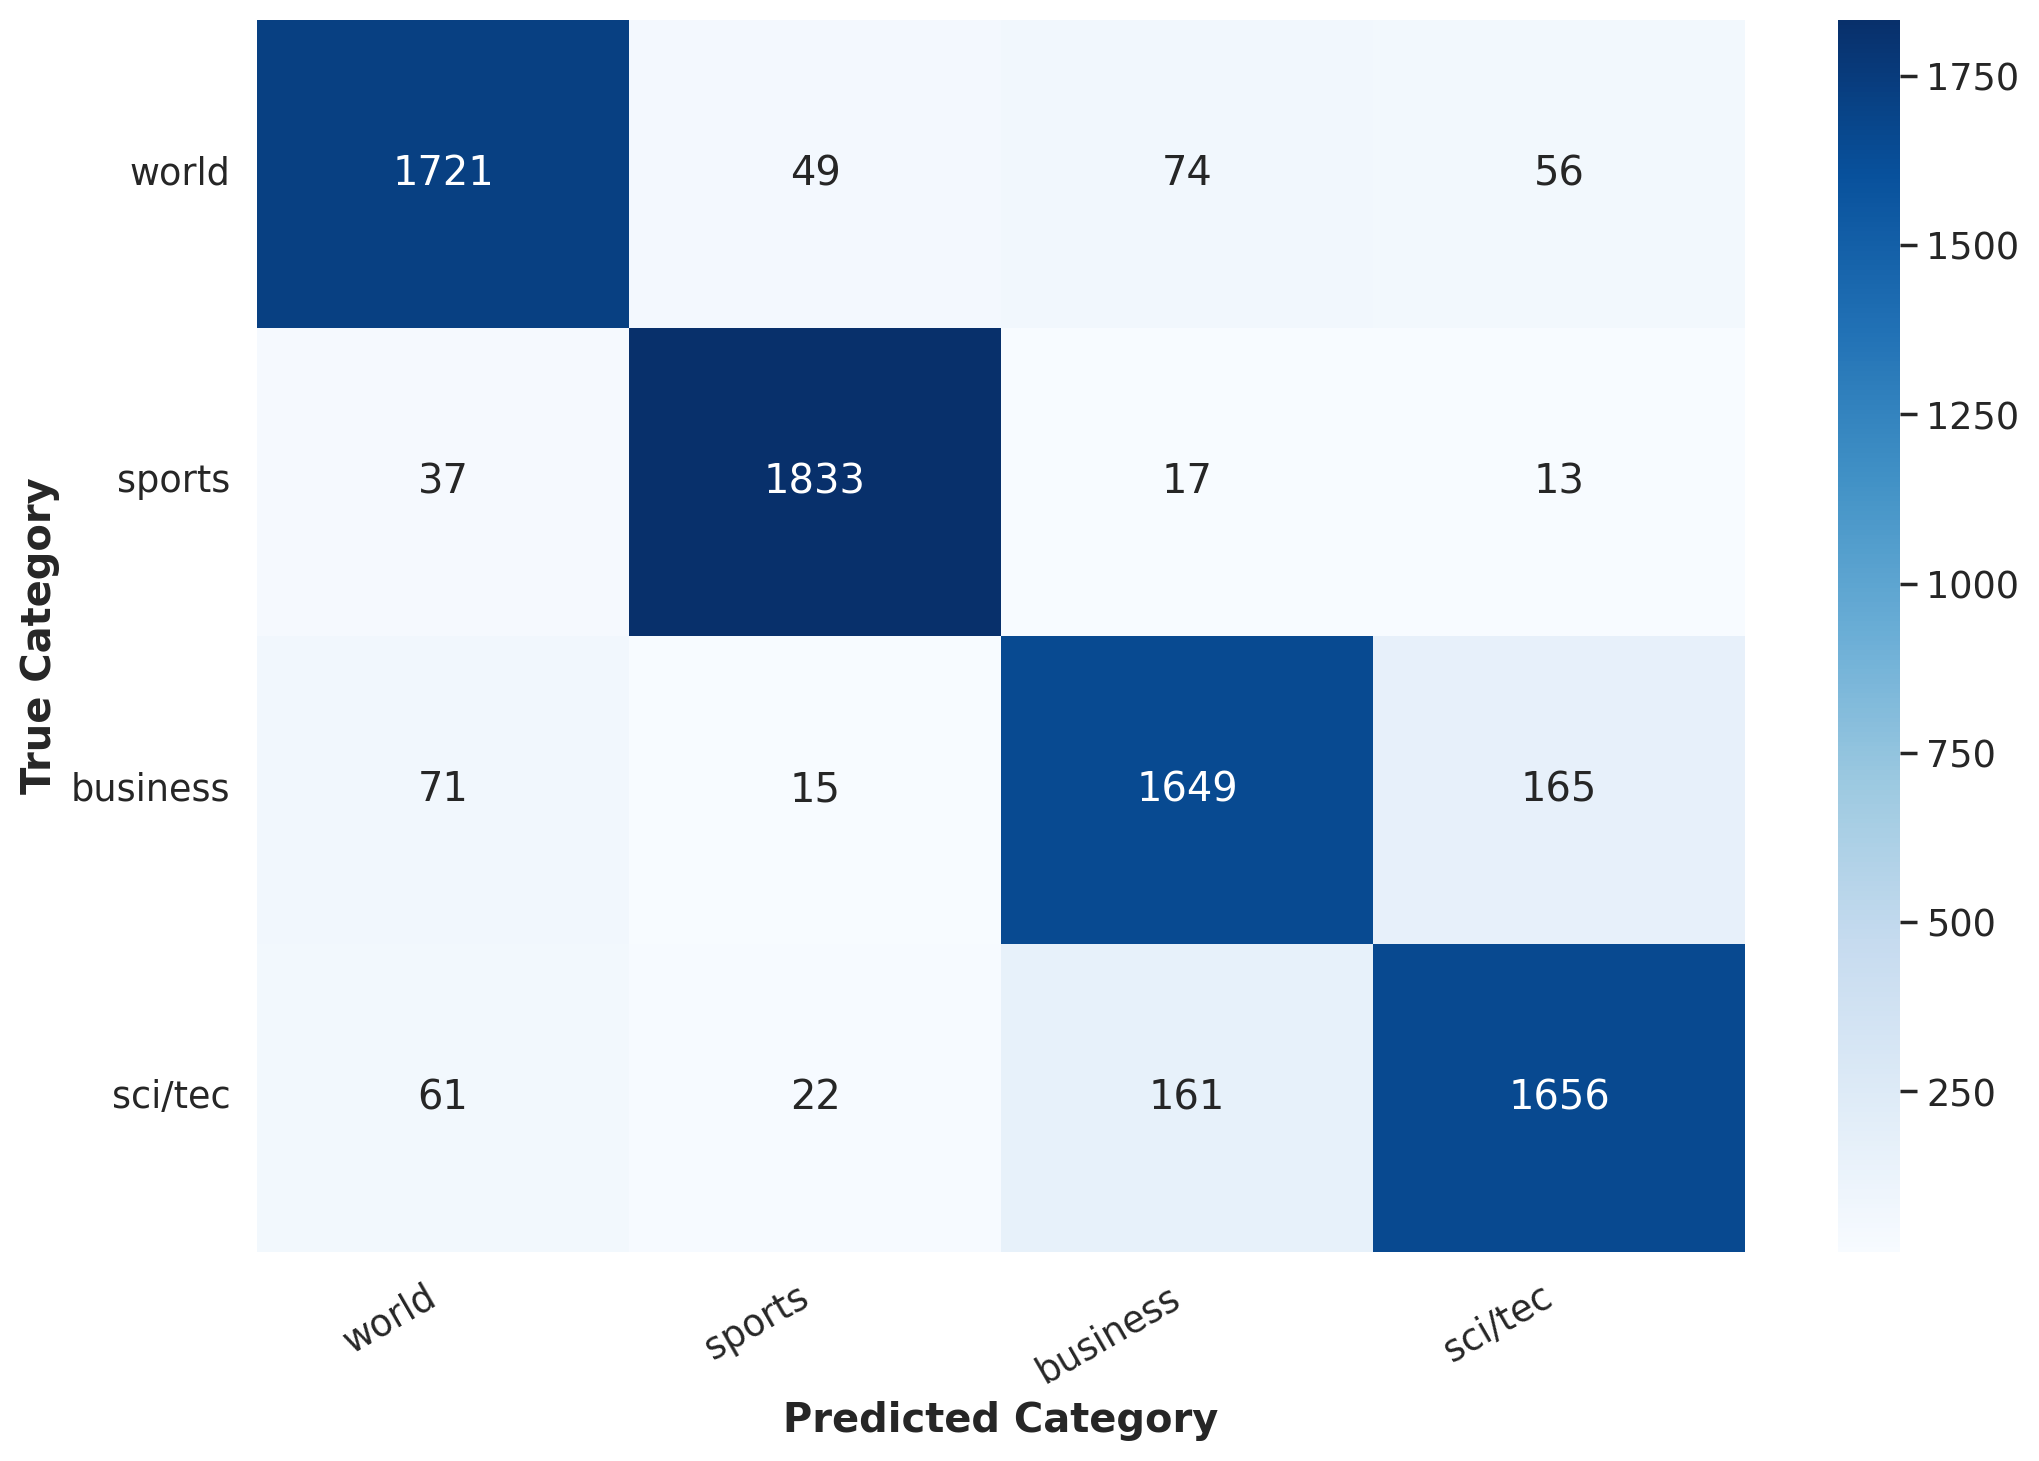

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha='right')
    plt.ylabel('True Category', fontweight='bold')
    plt.xlabel('Predicted Category', fontweight='bold')

y_pred, y_test, test_acc = get_predictions(eb_model, test_loader)
print(f'Test Accuracy: {test_acc}')
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns = class_names)
show_confusion_matrix(df_cm)

In [ ]:
test_label = 2  # {1: World, 2: Sports, 3: Business, 4: Sci/Tec}
test_line = ('US Men Have Right Touch in Relay Duel Against Australia THENS, Aug. 17 '
            '- So Michael Phelps is not going to match the seven gold medals won by Mark Spitz. '
            'And it is too early to tell if he will match Aleksandr Dityatin, '
            'the Soviet gymnast who won eight total medals in 1980.')

test_labels, test_text, test_offsets = collate_batch([(test_label, test_line)])

probs = F.softmax(eb_model(test_text, test_offsets), dim=1).squeeze(0)
print(probs)
print(test_labels[0])
print('Prediction probability:', round(probs[test_labels[0]].item(), 4))

tensor([5.3725e-02, 9.4382e-01, 8.8011e-04, 1.5747e-03],
       grad_fn=<SqueezeBackward1>)
tensor(1)
Prediction probability: 0.9438


In [ ]:
# remove the batch dimension for the embedding-bag model
def forward_func(text, offsets):
    return eb_model(text.squeeze(0), offsets)

# encode text indices into latent representations & calculate cosine similarity
def exp_embedding_cosine_distance(original_inp, perturbed_inp, _, **kwargs):
    original_emb = eb_model.embedding(original_inp, None)
    perturbed_emb = eb_model.embedding(perturbed_inp, None)
    distance = 1 - F.cosine_similarity(original_emb, perturbed_emb, dim=1)
    return torch.exp(-1 * (distance ** 2) / 2)

# binary vector where each word is selected independently and uniformly at random
def bernoulli_perturb(text, **kwargs):
    probs = torch.ones_like(text) * 0.5
    return torch.bernoulli(probs).long()

# remove absenst token based on the intepretable representation sample
def interp_to_input(interp_sample, original_input, **kwargs):
    return original_input[interp_sample.bool()].view(original_input.size(0), -1)

lasso_lime_base = LimeBase(
    forward_func,
    interpretable_model=SkLearnLasso(alpha=0.08),
    similarity_func=exp_embedding_cosine_distance,
    perturb_func=bernoulli_perturb,
    perturb_interpretable_space=True,
    from_interp_rep_transform=interp_to_input,
    to_interp_rep_transform=None
)

In [ ]:
attrs = lasso_lime_base.attribute(
    test_text.unsqueeze(0), # add batch dimension for Captum
    target=test_labels,
    additional_forward_args=(test_offsets,),
    n_samples=3200,
    show_progress=True
).squeeze(0)

print('Attribution range:', attrs.min().item(), 'to', attrs.max().item())

In [ ]:
def show_text_attr(attrs):
    rgb = lambda x: '255,0,0' if x < 0 else '0,255,0'
    alpha = lambda x: abs(x) ** 0.5
    token_marks = [
        f'<mark style="background-color:rgba({rgb(attr)},{alpha(attr)})">{token}</mark>'
        for token, attr in zip(tokenizer(test_line), attrs.tolist())
    ]

    display(HTML('<p>' + ' '.join(token_marks) + '</p>'))

show_text_attr(attrs)

In [ ]:
from operator import itemgetter

In [ ]:
# dict1 = {}
# world = Counter(dict1)

# for i in range(1000):
#   label, text = world_category[i]
#   test_labels, test_text, test_offsets = collate_batch([(label, text)])

#   attrs = lasso_lime_base.attribute(
#     test_text.unsqueeze(0), # add batch dimension for Captum
#     target=test_labels,
#     additional_forward_args=(test_offsets,),
#     n_samples=320,
#     show_progress=True
#   ).squeeze(0)
#   tokens = tokenizer(text)
#   weights = attrs.tolist()
#   for j in range(len(weights)):
#     dict1[tokens[j]] = weights[j]
#   world.update(dict1)

In [ ]:
# res = dict(sorted(world.items(), key=itemgetter(1), reverse=True)[:20])
# plt.bar(list(res.keys()), res.values(), color='b')
# plt.xticks(rotation=45, ha='right')
# plt.xlabel('tokens', fontweight='bold')
# plt.ylabel('weights', fontweight='bold')
# plt.show()

In [ ]:
# dict1 = {}
# business = Counter(dict1)

# for i in range(len(business_category)):
#   label, text = business_category[i]
#   test_labels, test_text, test_offsets = collate_batch([(label, text)])

#   attrs = lasso_lime_base.attribute(
#     test_text.unsqueeze(0), # add batch dimension for Captum
#     target=test_labels,
#     additional_forward_args=(test_offsets,),
#     n_samples=320,
#     show_progress=True
#   ).squeeze(0)
#   tokens = tokenizer(text)
#   weights = attrs.tolist()
#   for j in range(len(weights)):
#     dict1[tokens[j]] = weights[j]
#   business.update(dict1)

In [ ]:
# res = dict(sorted(business.items(), key=itemgetter(1), reverse=True)[:20])
# plt.bar(list(res.keys()), res.values(), color='b')
# plt.xticks(rotation=45, ha='right')
# plt.xlabel('tokens', fontweight='bold')
# plt.ylabel('weights', fontweight='bold')
# plt.show()

In [ ]:
# dict1 = {}
# sci_tec = Counter(dict1)

# for i in range(1000):
#   label, text = sci_tec_category[i]
#   test_labels, test_text, test_offsets = collate_batch([(label, text)])

#   attrs = lasso_lime_base.attribute(
#     test_text.unsqueeze(0), # add batch dimension for Captum
#     target=test_labels,
#     additional_forward_args=(test_offsets,),
#     n_samples=320,
#     show_progress=True
#   ).squeeze(0)
#   tokens = tokenizer(text)
#   weights = attrs.tolist()
#   for j in range(len(weights)):
#     dict1[tokens[j]] = weights[j]
#   sci_tec.update(dict1)

In [ ]:
# res = dict(sorted(sci_tec.items(), key=itemgetter(1), reverse=True)[:20])
# plt.bar(list(res.keys()), res.values(), color='b')
# plt.xticks(rotation=45, ha='right')
# plt.xlabel('tokens', fontweight='bold')
# plt.ylabel('weights', fontweight='bold')
# plt.show()